# ***Regression: Predicting Attraction Ratings***

This notebook handles:
 1. Preparing data for rating prediction
 2. Training regression models
 3. Evaluating model performance
 4. Saving the model pipeline for deployment

## **1. Data Preparation**

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load preprocessed data
print("Loading preprocessed data...")
modeling_df = pd.read_csv('preprocessed_tourism_data.csv')

# Features and target
print("\nPreparing features and target...")
X_reg = modeling_df.drop(['Rating', *[col for col in modeling_df.columns if 'VisitMode_y_' in col]], axis=1)
y_reg = modeling_df['Rating']

# Train-test split
print("Splitting data into train/test sets...")
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

# Scale features
print("Scaling features...")
scaler = StandardScaler()
X_train_reg_scaled = scaler.fit_transform(X_train_reg)
X_test_reg_scaled = scaler.transform(X_test_reg)

print("\nData preparation complete!")
print(f"Training set shape: {X_train_reg_scaled.shape}")
print(f"Test set shape: {X_test_reg_scaled.shape}")


Loading preprocessed data...

Preparing features and target...
Splitting data into train/test sets...
Scaling features...

Data preparation complete!
Training set shape: (42337, 33)
Test set shape: (10585, 33)


## **2. Model Training**

In [2]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Initialize models
models = {
    "Random Forest": RandomForestRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}

# Train and evaluate models
print("Training models...")
results = {}
for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_reg_scaled, y_train_reg)
    y_pred = model.predict(X_test_reg_scaled)
    
    # Calculate metrics
    results[name] = {
        "RMSE": mean_squared_error(y_test_reg, y_pred) ** 0.5,
        "R2": r2_score(y_test_reg, y_pred)
    }
    print(f"{name} trained - RMSE: {results[name]['RMSE']:.4f}, R2: {results[name]['R2']:.4f}")

# Display results
print("\nModel Performance Comparison:")
pd.DataFrame(results).T


Training models...

Training Random Forest...
Random Forest trained - RMSE: 0.1397, R2: 0.6712

Training XGBoost...
XGBoost trained - RMSE: 0.1356, R2: 0.6902

Training Gradient Boosting...
Gradient Boosting trained - RMSE: 0.1236, R2: 0.7428

Model Performance Comparison:


,RMSE,R2
Random Forest,0.139736,0.671182
XGBoost,0.135628,0.690232
Gradient Boosting,0.123584,0.742805


## **3. Saving Model Pipeline**

In [3]:
import joblib
import os

# Create directory if it doesn't exist
os.makedirs('tourism_models/rating_prediction', exist_ok=True)

# Save components
print("Saving model pipeline components...")
joblib.dump(models["Gradient Boosting"], 'tourism_models/rating_prediction/model.pkl')
joblib.dump(scaler, 'tourism_models/rating_prediction/scaler.pkl')

# Save feature information
feature_names = X_train_reg.columns.tolist()
joblib.dump(feature_names, 'tourism_models/rating_prediction/feature_names.pkl')

# Save feature template
feature_template = {name: 0 for name in feature_names}
joblib.dump(feature_template, 'tourism_models/rating_prediction/feature_template.pkl')

print("\nAll components saved successfully:")
print("- Model: tourism_models/rating_prediction/model.pkl")
print("- Scaler: tourism_models/rating_prediction/scaler.pkl")
print("- Feature names: tourism_models/rating_prediction/feature_names.pkl")
print("- Feature template: tourism_models/rating_prediction/feature_template.pkl")

Saving model pipeline components...

All components saved successfully:
- Model: tourism_models/rating_prediction/model.pkl
- Scaler: tourism_models/rating_prediction/scaler.pkl
- Feature names: tourism_models/rating_prediction/feature_names.pkl
- Feature template: tourism_models/rating_prediction/feature_template.pkl


## **4. Prediction Verification**

In [4]:
def predict_rating(input_features):
    """
    Predict attraction rating from input features
    Args:
        input_features: dict with available features (can be partial)
    Returns:
        Predicted rating (1-5)
    """
    # Load all required components
    model = joblib.load('tourism_models/rating_prediction/model.pkl')
    scaler = joblib.load('tourism_models/rating_prediction/scaler.pkl')
    feature_names = joblib.load('tourism_models/rating_prediction/feature_names.pkl')
    template = joblib.load('tourism_models/rating_prediction/feature_template.pkl')
    
    # Update template with provided features
    for key in input_features:
        if key in template:
            template[key] = input_features[key]
        else:
            print(f"Warning: Feature '{key}' not in original training data")
    
    # Create DataFrame with correct column order
    input_df = pd.DataFrame([template], columns=feature_names)
    
    # Scale and predict
    scaled_input = scaler.transform(input_df)
    return max(1, min(5, model.predict(scaled_input)[0]))

# Test prediction
print("\nTesting prediction function...")
test_sample = {
    'AvgRating': 4.5,
    'TotalVisits': 10,
    'RatingStd': 0.5,
    'UniqueAttractions': 5,
    'VisitModeProp_Solo': 0.3,
    'VisitModeProp_Family': 0.7,
    'AttractionType_Museum': 1,
    'ContinentId_Europe': 1,
    'Country_freq_encoded': 0.05,
    'VisitYear': 2023,
    'VisitMonth': 6,
    'IsWeekend': 0
}

try:
    predicted_rating = predict_rating(test_sample)
    print(f"Predicted Rating: {predicted_rating:.2f}")
except Exception as e:
    print(f"Prediction failed: {str(e)}")



Testing prediction function...
Predicted Rating: 1.02


## **5. Feature Importance Analysis**

<Figure size 1200x800 with 0 Axes>

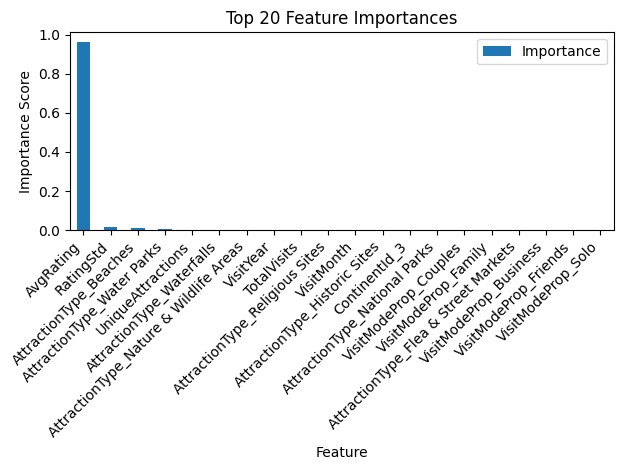

In [5]:
import matplotlib.pyplot as plt

# Load the best model
best_model = joblib.load('tourism_models/rating_prediction/model.pkl')

# Get feature importances
importances = best_model.feature_importances_
feature_importance = pd.DataFrame({
    'Feature': X_train_reg.columns,
    'Importance': importances
}).sort_values('Importance', ascending=False)

# Plot top 20 features
plt.figure(figsize=(12, 8))
feature_importance.head(20).plot.bar(x='Feature', y='Importance')
plt.title('Top 20 Feature Importances')
plt.ylabel('Importance Score')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## **6. Final Model Evaluation**

In [6]:
from sklearn.model_selection import cross_val_score

# Cross-validation on best model
print("Running cross-validation...")
cv_scores = cross_val_score(
    best_model,
    X_train_reg_scaled,
    y_train_reg,
    cv=5,
    scoring='neg_root_mean_squared_error'
)

print("\nCross-validation RMSE scores:")
print([f"{score:.4f}" for score in -cv_scores])
print(f"Mean RMSE: {-cv_scores.mean():.4f} (±{cv_scores.std():.4f})")

# Final test set evaluation
y_pred_final = best_model.predict(X_test_reg_scaled)
final_rmse = mean_squared_error(y_test_reg, y_pred_final) ** 0.5
final_r2 = r2_score(y_test_reg, y_pred_final)

print("\nFinal Test Set Performance:")
print(f"RMSE: {final_rmse:.4f}")
print(f"R2: {final_r2:.4f}")

Running cross-validation...

Cross-validation RMSE scores:
['0.1221', '0.1210', '0.1227', '0.1209', '0.1209']
Mean RMSE: 0.1215 (±0.0007)

Final Test Set Performance:
RMSE: 0.1236
R2: 0.7428
